In [2]:
import xwrf
from metpy.calc import wind_speed
from metpy.units import units
import xgcm
import numpy as np
import pint_xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

In [3]:
ds=xr.open_dataset('/ktyle_rit/mp856533/atm498/icestorm/exp1/wrfout_d01_2008-12-11_00:00:00', chunks='auto').xwrf.postprocess()

In [4]:
ds

<xarray.Dataset> Size: 646MB
Dimensions:                    (Time: 49, y: 49, x: 49, soil_layers_stag: 4,
                                z: 56, x_stag: 50, y_stag: 50, z_stag: 57,
                                num_stoch_levels: 57, seed_dim_stag: 2)
Coordinates: (12/15)
    XLAT                       (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG                      (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLAT_V                     (y_stag, x) float32 10kB dask.array<chunksize=(50, 49), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 228B 1.0 0.9938 ... 0.003327 0.0
  * Time                       (Time) datetime64[ns] 392B 2008-12-11 ... 2008...
  * x_stag                     (x_stag) float64 400B -8.82e+05 ... 8.82e+05
  * x                          (x) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
  * y                          (y) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
  * y_stag                     (y_stag) float64 400B -8.82e+05 ... 8.82e+05
Dimensions without coordinates: soil_layers_stag, num_stoch_levels,
                                seed_dim_stag
Data variables: (12/196)
    Times                      (Time) |S19 931B dask.array<chunksize=(49,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    ZS                         (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    DZS                        (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    BATHYMETRY_FLAG            (Time) int32 196B dask.array<chunksize=(49,), meta=np.ndarray>
    ...                         ...
    geopotential_height        (Time, z_stag, y, x) float32 27MB dask.array<chunksize=(5, 57, 49, 49), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_east_10               (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wind_north_10              (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wrf_projection             object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +...
Attributes: (12/141)
    TITLE:                            OUTPUT FROM WRF V4.5.1 MODEL
    START_DATE:                      2008-12-11_00:00:00
    SIMULATION_START_DATE:           2008-12-11_00:00:00
    WEST-EAST_GRID_DIMENSION:        50
    SOUTH-NORTH_GRID_DIMENSION:      50
    BOTTOM-TOP_GRID_DIMENSION:       57
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [5]:
ds = ds.drop_vars('O3_GFS_DU') # Avoids MetPy units-parsing error with Dobson units

In [6]:
wrf_proj = ds.wrf_projection

In [7]:
wrf_proj

<xarray.DataArray 'wrf_projection' ()> Size: 8B
array(<Projected CRS: +proj=lcc +x_0=0 +y_0=0 +a=6370000 +b=6370000 +lat ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich
, dtype=object)
Attributes: (12/16)
    crs_wkt:                        PROJCRS["unknown",BASEGEOGCRS["unknown",D...
    semi_major_axis:                6370000.0
    semi_minor_axis:                6370000.0
    inverse_flattening:             0.0
    reference_ellipsoid_name:       unknown
    longitude_of_prime_meridian:    0.0
    ...                             ...
    grid_mapping_name:              lambert_conformal_conic
    standard_parallel:              (40.0, 40.0)
    latitude_of_projection_origin:  40.000003814697266
    longitude_of_central_meridian:  -75.0
    false_easting:                  0.0
    false_northing:                 0.0

In [8]:
if (wrf_proj.grid_mapping_name == 'lambert_conformal_conic'):
    lat_1, lat_2 = wrf_proj.standard_parallel
    lat_0 = wrf_proj.latitude_of_projection_origin
    lon_0 = wrf_proj.longitude_of_central_meridian
    a = wrf_proj.semi_major_axis
    b = wrf_proj.semi_minor_axis
    proj_data= ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0,
                                standard_parallels=[lat_1,lat_2],
                                globe=ccrs.Globe(semimajor_axis=a, semiminor_axis=b))

In [9]:
destaggered = ds.xwrf.destagger().metpy.quantify()

In [10]:
destaggered.geopotential_height

<xarray.DataArray 'geopotential_height' (Time: 49, z: 56, y: 49, x: 49)> Size: 26MB
<Quantity(dask.array<mul, shape=(49, 56, 49, 49), dtype=float32, chunksize=(5, 56, 49, 49), chunktype=numpy.ndarray>, 'meter')>
Coordinates:
    XTIME    (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
  * Time     (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
    XLAT     (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG    (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    CLAT     (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
  * x        (x) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * y        (y) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * z        (z) float32 224B 0.9969 0.9899 0.981 ... 0.008745 0.005096 0.001663
Attributes:
    standard_name:  geopotential_height
    grid_mapping:   wrf_projection

In [11]:
target_levels = np.array([500.])
air_pressure = destaggered.air_pressure.pint.to('hPa').metpy.dequantify()
grid = xgcm.Grid(destaggered, periodic=False)
geo= grid.transform(destaggered.geopotential_height.metpy.dequantify(), 'Z', target_levels, target_data=air_pressure, method='log')
Geo = geo.compute()

/knight/jan25/envs/jan25_env/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


In [13]:
Geo = Geo/10
Geo

<xarray.DataArray 'geopotential_height' (Time: 49, y: 49, x: 49, air_pressure: 1)> Size: 941kB
<Quantity([[[[576.68737651]
   [577.02846866]
   [577.39621592]
   ...
   [587.66005323]
   [587.7291737 ]
   [587.74636516]]

  [[576.32048812]
   [576.66522508]
   [577.02906552]
   ...
   [587.60192389]
   [587.70790805]
   [587.74656159]]

  [[576.02648202]
   [576.34059916]
   [576.67537234]
   ...
...
   ...
   [551.29373384]
   [552.63814608]
   [553.89418972]]

  [[524.40175848]
   [524.33406305]
   [524.29279226]
   ...
   [550.32687507]
   [551.6827352 ]
   [553.16203188]]

  [[523.52641853]
   [523.19755478]
   [523.24643409]
   ...
   [549.67084661]
   [550.88496562]
   [552.40847119]]]], 'decameter')>
Coordinates:
    XTIME         (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
  * Time          (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
    XLAT          (y, x) float32 10kB 31.86 31.89 31.92 ... 47.33 47.29 47.25
    XLONG         (y, x) float32 10kB -84.08 -83.7 -83.32 ... -64.08 -63.61
    CLAT          (y, x) float32 10kB 31.86 31.89 31.92 ... 47.33 47.29 47.25
  * x             (x) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * y             (y) float64 392B -8.64e+05 -8.28e+05 ... 8.28e+05 8.64e+05
  * air_pressure  (air_pressure) float64 8B 500.0

<a list of 10 text.Text objects>

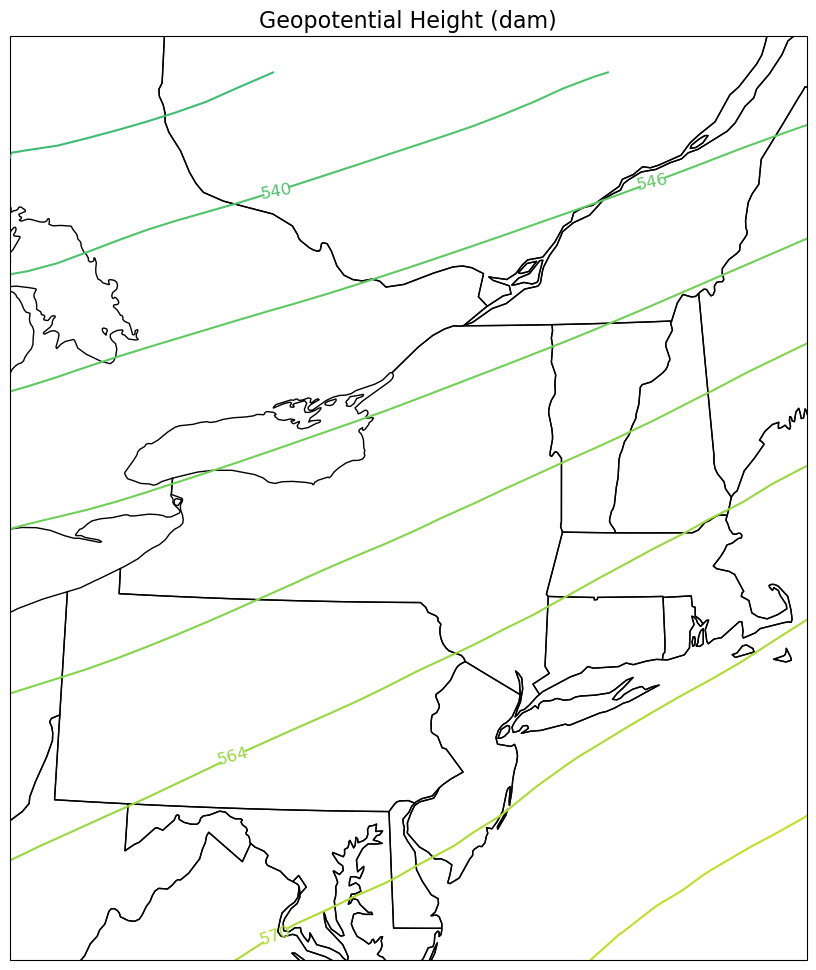

In [21]:
fint=np.arange(402,600,6)
latN = 48
latS = 38
lonW = -81
lonE = -70

res = '50m'

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1,1,1,projection=proj_data)
ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))
#Add new title
tl1 = 'Geopotential Height (dam)'
ax.set_title(f'{tl1}',fontsize=16)
C = ax.contour(Geo.x,Geo.y, Geo.isel(Time=12).squeeze(),levels=fint)
ax.clabel(C, inline=1, fontsize=12)